In [28]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import numpy as np

from scipy import stats
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20220720',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }


sns.set(rc={'figure.figsize':(12,10)},
       style = 'whitegrid',
       font_scale = 1.3)

In [2]:
# сгружаем наши данные за нужный период:

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-06-13' and '2022-06-19'
    and exp_group in (2,1)
GROUP BY exp_group, user_id
"""

In [3]:
df = ph.read_clickhouse(q, connection=connection)

In [4]:
df

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750
...,...,...,...,...,...
20026,1,132567,45,296,0.152027
20027,1,30872,11,59,0.186441
20028,2,25383,42,127,0.330709
20029,2,139020,24,114,0.210526


In [5]:
# кол-во юзеров в группах ~ одинаково:

df.exp_group.value_counts()

1    10079
2     9952
Name: exp_group, dtype: int64

In [6]:
# ctr в обеих группах ~ одинаков:
    
df.groupby('exp_group').ctr.mean()

exp_group
1    0.215605
2    0.214419
Name: ctr, dtype: float64

<AxesSubplot:xlabel='ctr', ylabel='Count'>

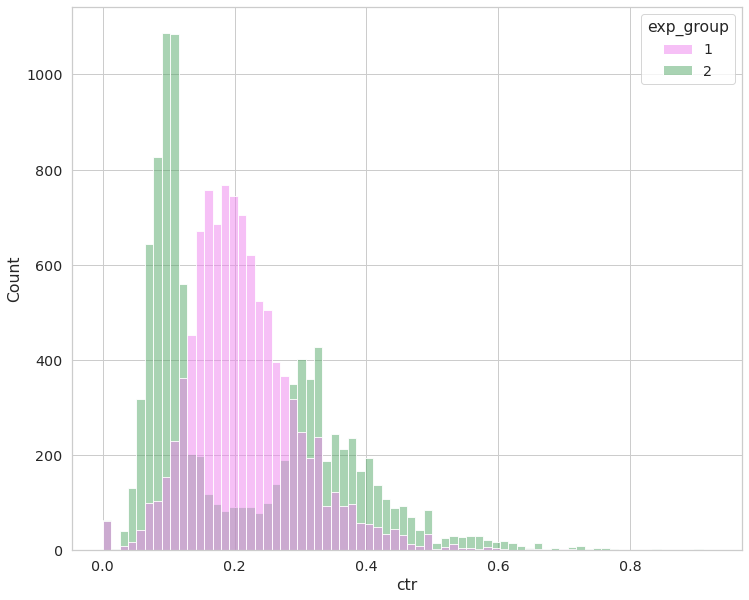

In [8]:
# строим распределения ctr для двух групп, видим, что они не одинаковы, в контрольной группе 1 распределение больше похоже на нормальное,
# в тестовой группе 2 распределение бимодальное:

sns.histplot(data = df,
            x = 'ctr',
            hue = 'exp_group',
            palette = ['violet','g'],
            kde = False,
            alpha = 0.5)

<AxesSubplot:xlabel='exp_group', ylabel='ctr'>

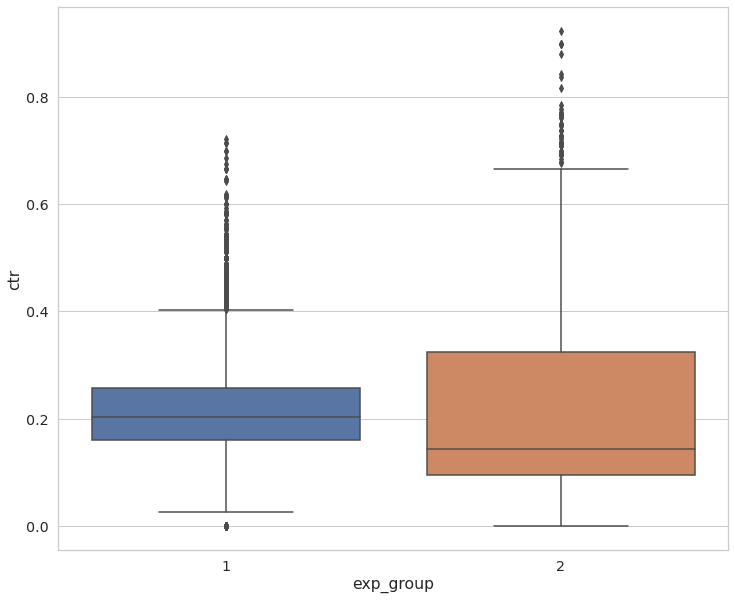

In [13]:
sns.boxplot(x="exp_group", y="ctr", data=df)

In [ ]:
# Для обеих групп проведем Шапиро-Уилк тест для определения нормальности распределений (проведем сэмплирование, т.к.
# на больших выборках тест может показать неверный результат):

In [11]:
stats.shapiro(df[df.exp_group == 1].ctr.sample(1000, random_state=17))

ShapiroResult(statistic=0.9535661935806274, pvalue=3.0551856367641973e-17)

In [12]:
stats.shapiro(df[df.exp_group == 2].ctr.sample(1000, random_state=17))

ShapiroResult(statistic=0.8981765508651733, pvalue=3.255634625784872e-25)

В обеих группах тест на нормальность показывает, что распределения не нормальны (p-value < 0.05), но т.к. кол-во наблюдений большое, то t-тест может быть использован.

In [9]:
# проводим t-тест:

stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

По результатам t-test'а имеем p_value > 0.05, вероятность получить такие или более сильные различия в ctr 
при условии, что H0 верна - 47,8%, а значит, у нас нет оснований отклонить H0 о равенстве средних - не имеем статистически значимого результата.

In [10]:
# Еще одним требованием для проведения t-теста является требования гомогенности дисперсий - дисперсии наших групп должны быть примерно одинаковы.
# Для проверки используем тест Левена:

stats.levene(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr)

# Получаем pvalue=0.0, а значит требование о гомогенности дисперсий не соблюдается. Можно ли верить результату одного t-теста в данном случае? (─‿‿─)

LeveneResult(statistic=2423.1112173147503, pvalue=0.0)

In [14]:
# Проведем тест Манна-Уитни:

stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr)

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

p_value < 0.05, вероятность получить такие или более сильные различия в ctr при условии, что H0 верна <5%, а значит, у нас есть основания отклонить H0 о равенстве средних - имеем статистически значимый результат.

In [16]:
# Проведем t-тест на сглаженном ctr:


# Функция сглаживания:

def get_smoothed_ctr(user_likes, user_views, global_ctr, alpha):
    smoothed_ctr = (user_likes + alpha*global_ctr) / (user_views + alpha*global_ctr)
    return smoothed_ctr

In [17]:
global_ctr1 = df[df['exp_group'] == 1].likes.sum() / df[df['exp_group']== 1].views.sum()
global_ctr2 = df[df['exp_group'] == 2].likes.sum() / df[df['exp_group']== 2].views.sum()

In [19]:
group1 = df[df.exp_group == 1].copy()

group1['smothed_ctr'] = df.apply(
    lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr1, alpha = 5), axis=1)

group2 = df[df.exp_group == 2].copy()
group2['smothed_ctr'] = df.apply(
    lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr2, alpha = 5), axis=1)


<AxesSubplot:xlabel='ctr'>

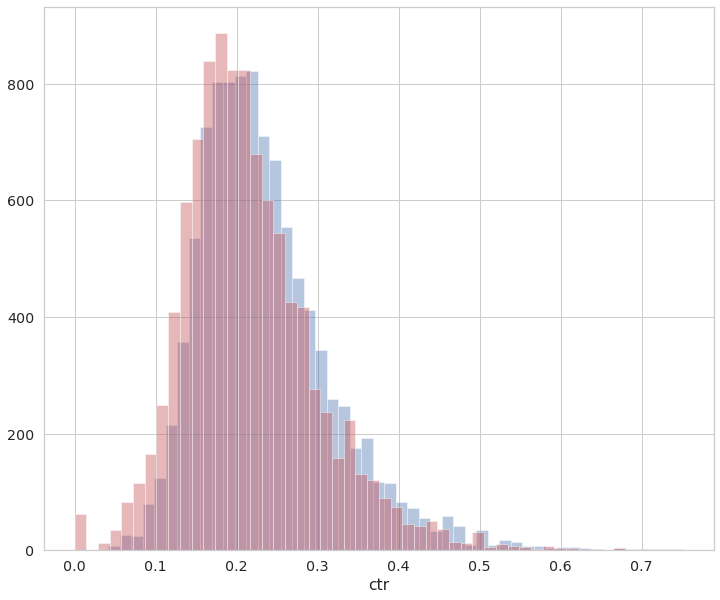

In [24]:
# Построим распределения для 1 группы - исходное и сглаженное:

sns.distplot(group1.smothed_ctr, 
             kde = False,
             color = 'b')

sns.distplot(df[df.exp_group ==1].ctr,
             kde = False,
             color = 'r')


<AxesSubplot:xlabel='ctr'>

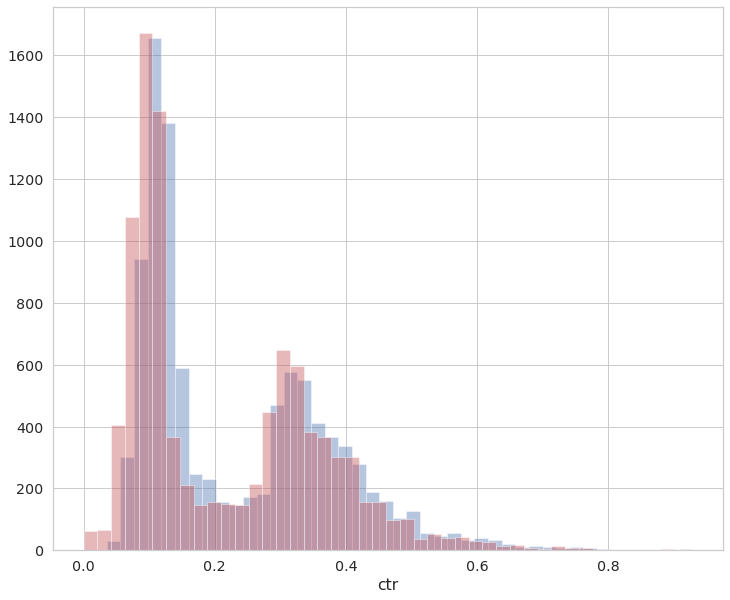

In [25]:
# Построим распределения для 2 группы - исходное и сглаженное:

sns.distplot(group2.smothed_ctr, 
             kde = False,
             color = 'b')

sns.distplot(df[df.exp_group == 2].ctr,
             kde = False,
             color = 'r')


In [26]:
# Проводим t-тест на сглаженном ctr:

stats.ttest_ind(group1.smothed_ctr,
                group2.smothed_ctr,
                equal_var=False)

Ttest_indResult(statistic=1.233208024529151, pvalue=0.21751618626824193)

По результатам t-test'а имеем p_value > 0.05, вероятность получить такие или более сильные различия в ctr при условии, что H0 верна - 21,7%, а значит, у нас нет оснований отклонить H0 о равенстве средних - не имеем статистически значимого результата.

<AxesSubplot:ylabel='Count'>

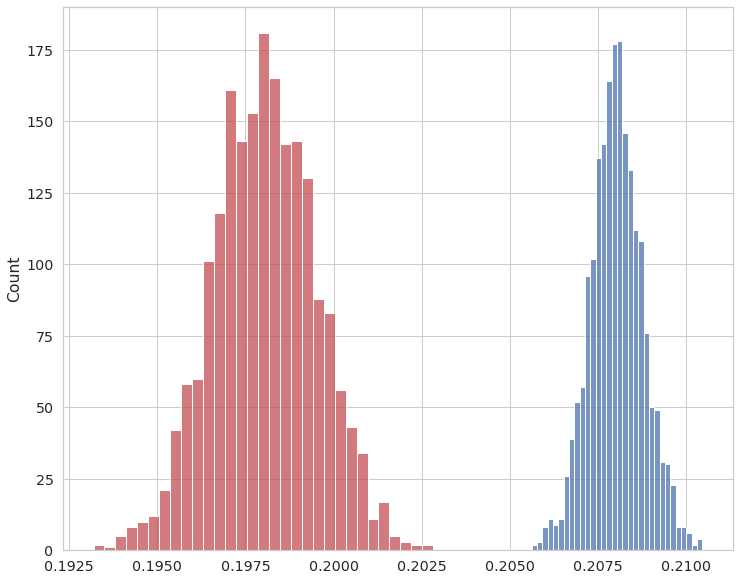

In [31]:
# Проведем Пуассоновский бутстрап для подсчета разнпицы в ctr:

def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    poisson_bs1 = stats.poisson(1).rvs((n_bootstrap, len(likes1))).astype(np.int64)
    
    poisson_bs2 = stats.poisson(1).rvs((n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bs1*likes1).sum(axis=1)/(poisson_bs1*views1).sum(axis=1)
    globalCTR2 = (poisson_bs2*likes2).sum(axis=1)/(poisson_bs2*views2).sum(axis=1)
    
    return globalCTR1, globalCTR2


likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()


ctr1, ctr2  = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1, color ='b')
sns.histplot(ctr2, color = 'r')


<AxesSubplot:ylabel='Count'>

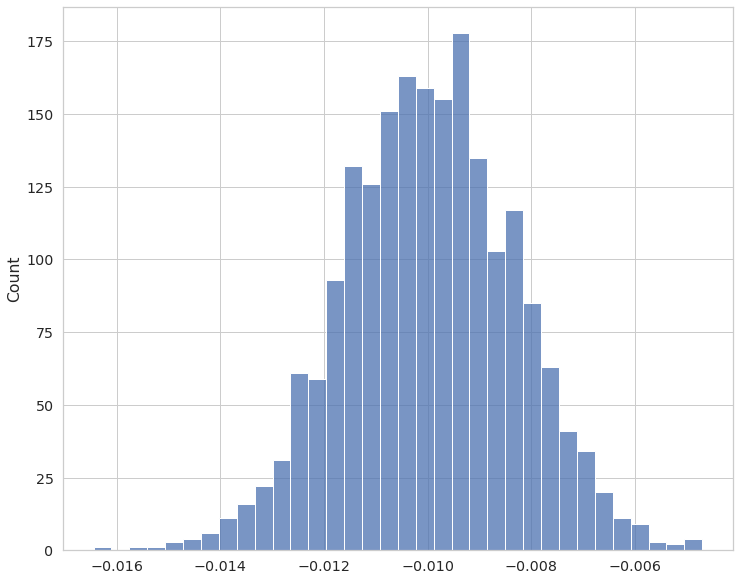

In [32]:
sns.histplot(ctr2-ctr1)

По графикам видим, что распределения двух групп даже не перекрываются, в контрольной группе 1 ctr больше, чем в тестовой группе 2.

In [35]:
# Применяем t-test и тест Манни- Уитни поверх бакетного преобразования :

q1 = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM simulator_20220720.feed_actions
    WHERE toDate(time) between '2022-06-13' and '2022-06-19'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df1 = ph.read_clickhouse(q1, connection=connection)


In [36]:
df1

,exp_group,bucket,bucket_ctr,ctr9
0,1,0,0.196481,0.307692
1,2,0,0.194262,0.384615
2,1,1,0.211887,0.318182
3,2,1,0.215328,0.467742
4,1,2,0.206271,0.322314
...,...,...,...,...
95,2,47,0.195880,0.426230
96,1,48,0.212787,0.318182
97,2,48,0.194502,0.409091
98,1,49,0.203169,0.325581


<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

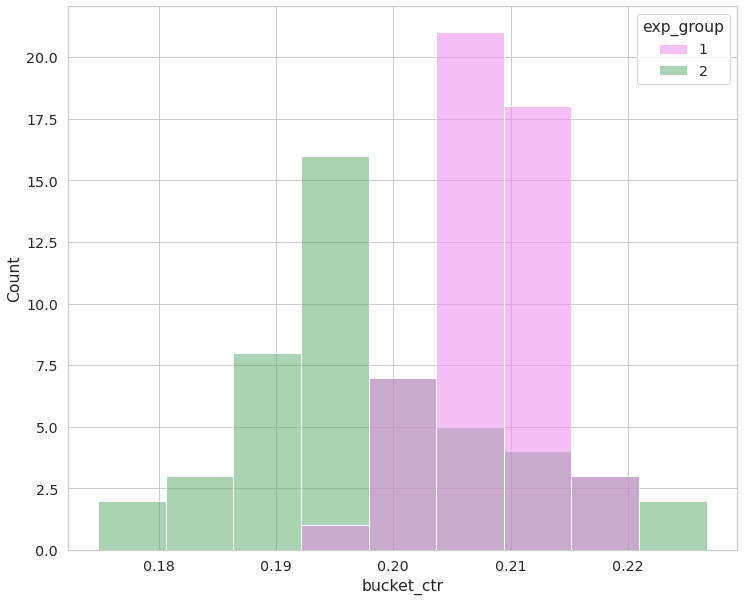

In [37]:
sns.histplot(data = df1,
            x = 'bucket_ctr',
            hue = 'exp_group',
            palette = ['violet','g'],
            kde = False,
            alpha = 0.5)

In [39]:
# Проведем тест Манна-Уитни:

stats.mannwhitneyu(df1[df1.exp_group == 1].bucket_ctr,
                df1[df1.exp_group == 2].bucket_ctr)

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

In [40]:
# и t-тест:

stats.ttest_ind(df1[df1.exp_group == 1].bucket_ctr,
                df1[df1.exp_group == 2].bucket_ctr)

Ttest_indResult(statistic=5.668234732053979, pvalue=1.4532650505355013e-07)

В обоих тестах p_value < 0.05, вероятность получить такие или более сильные различия в ctr при условии, что H0 верна <5%, а значит, у нас есть основания отклонить H0 о равенстве средних - имеем статистически значимый результат.


Считаю, что т.к. исходное распределение ctr в тестовой группе 2 бимодальное, стоит больше доверять таким методам, как бутстрап, который показал нам, что в тестовой группе 2 ctr снизился - изменения лучше не выкатывать. Также считаю, что полезно было бы понять, почему наши пользователи разделились на две группы (два горба в бимодальном распределении)